In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

import sys
sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import particles.mcmc as mcmc
import particles.state_space_models as ssm
import particles.distributions as dists
from particles.core import SMC
from particles import smc_samplers as ssp
import seaborn
from tqdm import tqdm
import pickle
import os

path = r'C:\Users\dobau\Desktop\3A ENSAE\S1\Hidden Markov Chain and MCMC\Project\res'
from Utils import *

## Problem

The data are constituted of two independent counts of kangaroos population in New South Wales (Australia). Data are from Knape & De Valpine (2012). We aim to fit different population growth models on the historical data in order to predict the unobserved real population size from the countings.

Some global variables are defined in Utils.ssm, to help the readability of this notebook. For instance `data` (dataframe with the couns), `dt` which is the time difference between the observations, or `y` which puts the data in a correct format to use the particles package developped by N. Chopin.

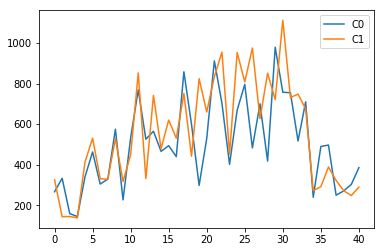

In [19]:
data[['C0','C1']].plot()

C0    4.976734
C1    4.927254
dtype: float64 (C0    6.886532
C1    7.013915
dtype: float64, (C0    6.115386
C1    6.173569
dtype: float64, C0    0.464843
C1    0.547350
dtype: float64))


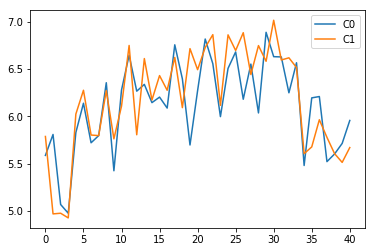

In [7]:
L_data = np.log(data[['C0', 'C1']])
L_data.plot()
print(L_data.min(), (L_data.max(), (L_data.mean(), L_data.std())))

In [8]:
print(mean_N0, std_N0) # Parameters for the initial distribution

296.5 29.5


In [9]:
n_particles = 4000
n_iter = 2000

# Definition of a Logistic Diffusion State-Space Models

The `LogisticDiffusion` state-space model is a model with the following dynamic for the unobserved variable:

$$ \frac{dy_t}{y_t} = (r+\frac{\sigma^2}{2}-b\times y_t)dt + \sigma dW_t$$

In our experiments we are just going to discretize this equation as follow:

$$ log(y_{t+1}) = log(y_t) + (r+\frac{\sigma^2}{2}-b\times y_t)\Delta_t + \sigma N(0, \Delta_t) $$

If we implement the model considering $z_t = log(y_t)$, we simply get:

$$ z_{t+1} \sim N(z_t + (r+\frac{\sigma^2}{2}-b\times exp(z_t))\Delta_t, \Delta_t )$$ 

This is the transition distribution, for the emission distribution we simply use a negative binomial distribution with mean $y_t$ and variance $y_t + \tau y_t^2$.

In Knape & De Valpine (2012), three models are considered:
* Model 1: parameters are r, b, $\sigma$
* Model 2: b=0, parameters are r and $\sigma$
* Model 3: r=b=0, the only parameter is $\sigma$

We add a first simple model for the case where $\tau$ is also set to 0 (so the emission distribution because a Poisson of rate $y_t$).

## Tests with all models

### A Random Walk Model with Poisson emission distribution

In [3]:
prior_RWp = {'sigma': dists.Uniform(a=0.,b=10.)}
load_model = True

if load_model:
    pmmh_RWp = pickle.load(open( os.path.join(path,"RWp_model.pkl"), "rb" ))
else:
    p_RWp = dists.StructDist(prior_RWp)
    pmmh_RWp = mcmc.PMMH(ssm_cls=RandomWalk2D_poisson, prior=p_RWp, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_RWp.run()
    pickle.dump(pmmh_RWp, open(os.path.join(path,"RWp_model.pkl"), "wb" ))

mean square jump distance: 10.033131766247525
posterior loglikelihood: [-1041.12949081 -1042.41819625 -1042.41819625 -1042.41819625
 -1042.41819625]
Acceptance rate: 0.40820410205102553
Last terms of theta chain: [(0.91182118,) (0.91182118,) (0.91182118,)]


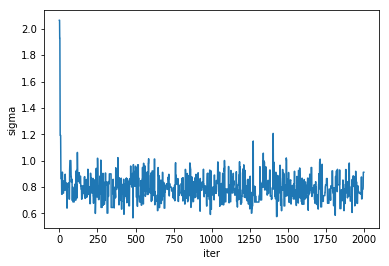

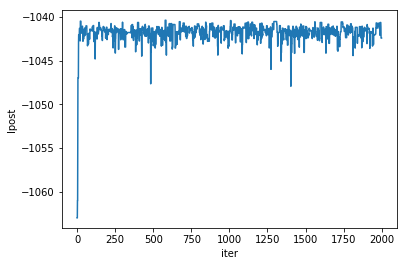

In [4]:
print_metrics(pmmh_RWp)
plot_theta(prior_RWp, pmmh_RWp)

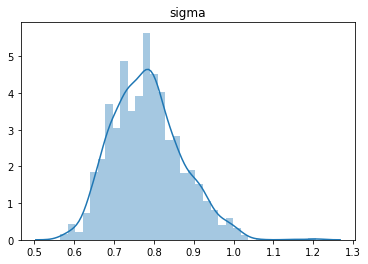

In [32]:
distplot(prior_RWp, pmmh_RWp, 250)

In [33]:
simulRWp = get_trajectories(N=100, start=500, model='poisson', pmmh=pmmh_RWp, n_particles=10000)

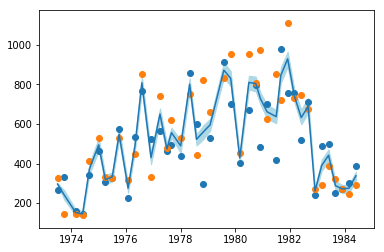

In [34]:
plot_posterior_trajectories(simulRWp)

## Random Walk Model (M3)

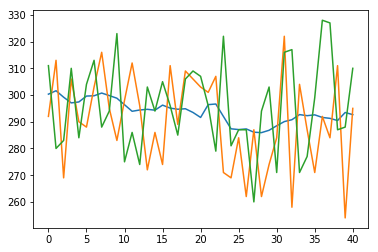

In [36]:
RW = RandomWalk2D(sigma=0.01,tau=0.0001) # An example
simulate_plot(RW)

In [37]:
prior_RW = {'tau': dists.Uniform(a=0.,b=1.),'sigma': dists.Uniform(a=0.,b=10.)}
p_RW = dists.StructDist(prior_RW)

load_model = False

if load_model:
    pmmh_RW = pickle.load(open( os.path.join(path,"RW_model.pkl"), "rb" ))
else:
    pmmh_RW= mcmc.PMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_RW.run()
    # pickle.dump(pmmh_RW, open( os.path.join(path,"RW_model.pkl"), "wb" ) )

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:53<00:00, 11.55it/s]


mean square jump distance: 12.788837124586376
posterior loglikelihood: [-536.75539493 -536.75539493 -536.75539493 -536.75539493 -536.75539493]
Acceptance rate: 0.35567783891945975
Last terms of theta chain: [(0.47473936, 0.058268) (0.47473936, 0.058268) (0.47473936, 0.058268)]


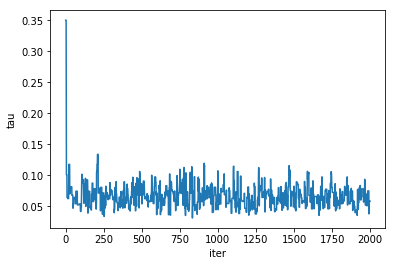

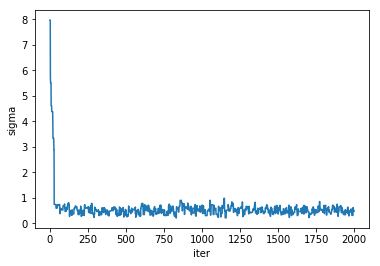

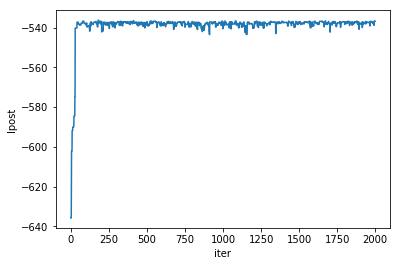

In [38]:
print_metrics(pmmh_RW)
plot_theta(prior_RW,pmmh_RW)

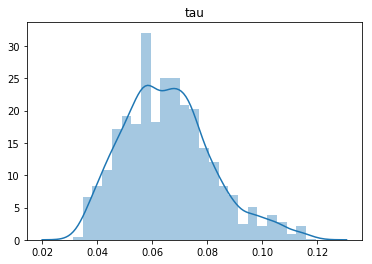

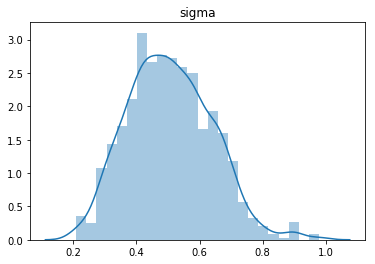

In [39]:
distplot(prior_RW, pmmh_RW, 500)

In [40]:
simulRW = get_trajectories(N=100, start=500, model='RW', pmmh=pmmh_RW, n_particles=10000)

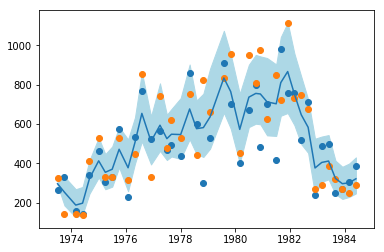

In [41]:
plot_posterior_trajectories(simulRW)

## Exponential growth (M2)

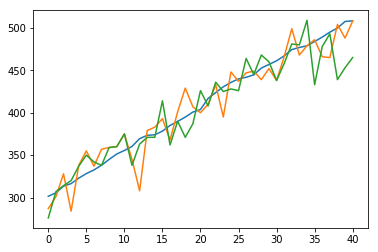

In [42]:
Ldrift = LDPDrift(sigma=0.01,tau=0.0001, r=0.05)
simulate_plot(Ldrift)

In [43]:
prior_Ldrift = {'tau': dists.Uniform(a=0.,b=1.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}

load_model = False

if load_model:
    pmmh_Ldrift = pickle.load(open( os.path.join(path,"Ldrift_model.pkl"), "rb" ))
else:
    p_Ldrift = dists.StructDist(prior_Ldrift)
    pmmh_Ldrift= mcmc.PMMH(ssm_cls=LDPDrift, prior=p_Ldrift, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_Ldrift.run()
    # pickle.dump(pmmh_Ldrift, open( os.path.join(path,"Ldrift_model.pkl"), "wb" ) )

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:00<00:00,  7.37it/s]


mean square jump distance: 25.50623500869865
posterior loglikelihood: [-540.66232484 -540.66232484 -540.66232484 -539.78349372 -539.78349372]
Acceptance rate: 0.3491745872936468
Last terms of theta chain: [(-0.02098699, 0.68466052, 0.05414488)
 ( 0.05159888, 0.57542251, 0.04901764)
 ( 0.05159888, 0.57542251, 0.04901764)]


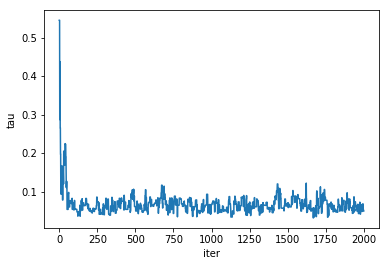

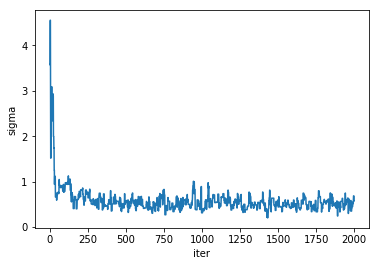

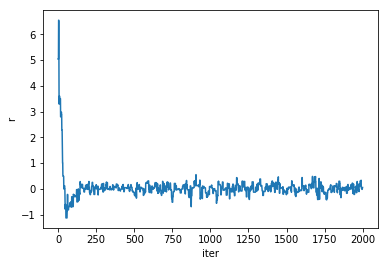

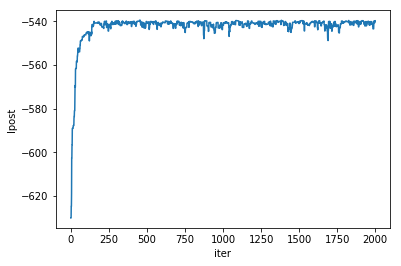

In [44]:
print_metrics(pmmh_Ldrift)
plot_theta(prior_Ldrift,pmmh_Ldrift)

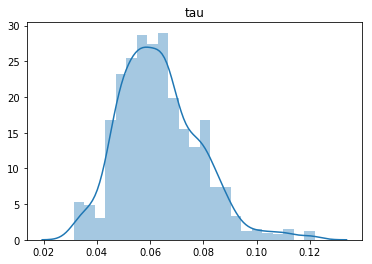

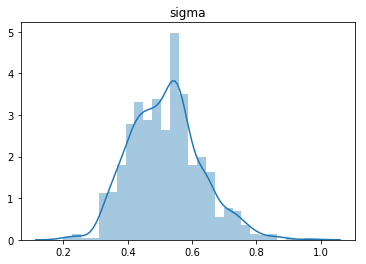

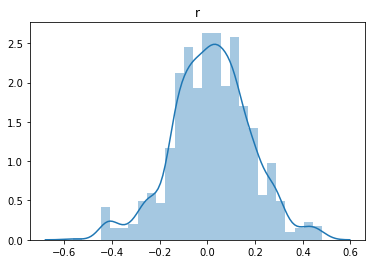

In [45]:
distplot(prior_Ldrift,pmmh_Ldrift,1000)

In [46]:
simulLDrift = get_trajectories(N=100, start=500, model='LDrift', pmmh=pmmh_Ldrift, n_particles=10000)

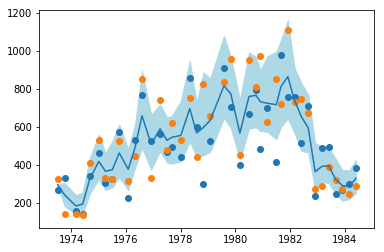

In [47]:
plot_posterior_trajectories(simulLDrift)

## Logistic Diffusion process with drift and restoring force: No Euler discretization

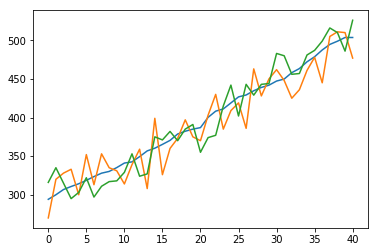

In [48]:
LD = LogisticDiffusion2D(sigma=0.01,k=0.0001, r=0.005, b=1e-6)
simulate_plot(Ldrift)

In [49]:
prior_LD = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=1e-2),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = False

if load_model:
    pmmh_LD = pickle.load(open( os.path.join(path,"LD_model.pkl"), "rb" ))
else:
    p_LD = dists.StructDist(prior_LD)
    pmmh_LD= mcmc.PMMH(ssm_cls=LogisticDiffusion2D, prior=p_LD, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_LD.run()
    pickle.dump(pmmh_LD, open( os.path.join(path,"LD_model.pkl"), "wb" ) )

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:36<00:00, 12.11it/s]


mean square jump distance: 32.57110405495644
posterior loglikelihood: [-535.8359674  -535.8359674  -535.8359674  -535.65526519 -535.65526519]
Acceptance rate: 0.26313156578289143
Last terms of theta chain: [(8.88472158e-05, 0.15518279, 0.51977919, 0.05457576)
 (6.44859180e-05, 0.00050616, 0.51196264, 0.06087925)
 (6.44859180e-05, 0.00050616, 0.51196264, 0.06087925)]


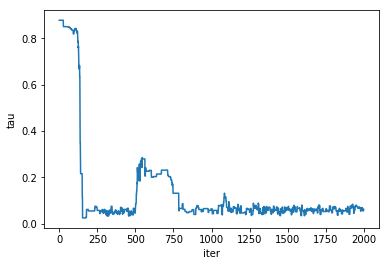

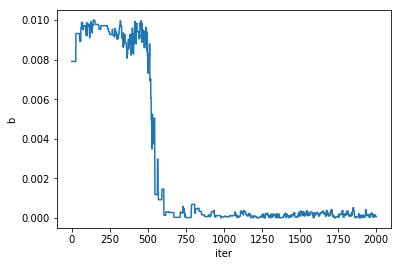

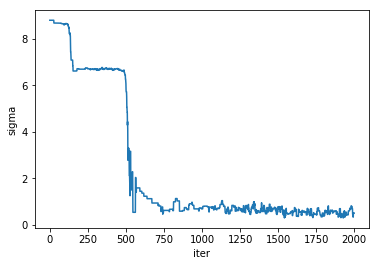

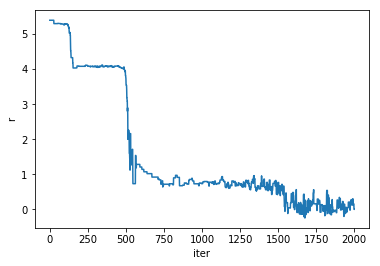

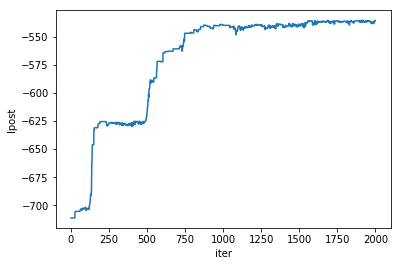

In [50]:
print_metrics(pmmh_LD)
plot_theta(prior_LD,pmmh_LD)

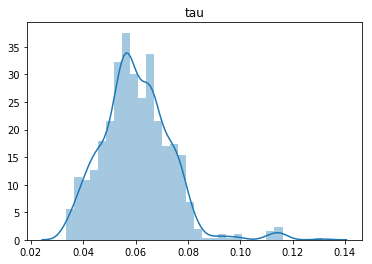

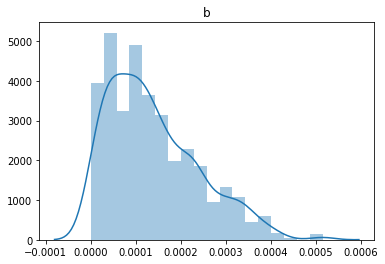

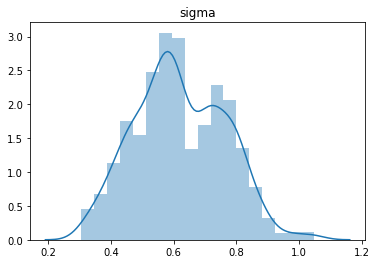

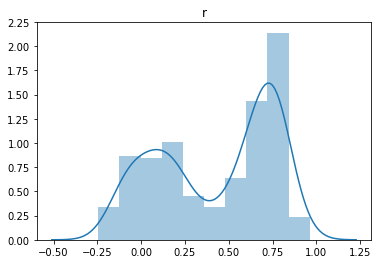

In [54]:
distplot(prior_LD,pmmh_LD, 1000)

In [55]:
simulLD = get_trajectories(N=100, start=1000, model='LD', pmmh=pmmh_LD, n_particles=10000)

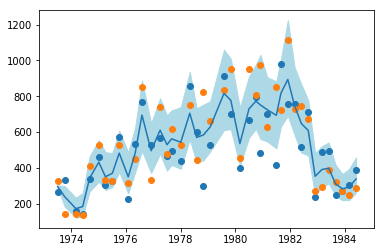

In [56]:
plot_posterior_trajectories(simulLD)

In [64]:
pmmh_LD.chain.theta

array([(7.91059677e-03, 5.39457177e+00, 8.7902999 , 0.87889245),
       (7.91059677e-03, 5.39457177e+00, 8.7902999 , 0.87889245),
       (7.91059677e-03, 5.39457177e+00, 8.7902999 , 0.87889245), ...,
       (8.88472158e-05, 1.55182788e-01, 0.51977919, 0.05457576),
       (6.44859180e-05, 5.06155243e-04, 0.51196264, 0.06087925),
       (6.44859180e-05, 5.06155243e-04, 0.51196264, 0.06087925)],
      dtype=[('b', '<f8'), ('r', '<f8'), ('sigma', '<f8'), ('tau', '<f8')])

## Logistic Diffusion process with Euler Discretization (M1)

### A first test

Before testing the discretized version of the LDP, we try to look at the regions that could provide good results. My idea is that for fixed value of \sigma, \tau, and particularly r they will be only a fe possibilities for b to get a good likelihood. To test this intuition, I looked at the value of b that provided the standard error which is the closest to the one of the original sample. If we plot this optimal b according to r we get a quite linear result.

In [182]:
# Find a value of b for a given r that provides an output "close" to the actual data

b_val = np.linspace(0, 0.02, 200)
r_list = np.linspace(0,6,12)
b_min = []
for r in r_list:
    print(r)
    std_diff = []
    for x in b_val:
        my_ssm = LDEuler(r=r, b=x, sigma=0.6, tau=0.06)
        X, y = my_ssm.simulate(41)
        Z = np.zeros((41,2))
        for i in range(40):
            Z[i] = y[i]
        std_diff.append((np.std(Z, axis=0).mean()-data[['C0', 'C1']].std().mean())**2)
    b_min.append(b_val[np.argmin(std_diff)])

0.0
0.5454545454545454
1.0909090909090908
1.6363636363636362
2.1818181818181817
2.727272727272727
3.2727272727272725
3.818181818181818
4.363636363636363
4.909090909090908
5.454545454545454
6.0


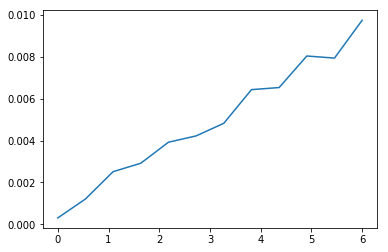

In [183]:
plt.plot(r_list, b_min)
plt.show()

33969.47995674779
40
0.0 1203.0 491.2317073170732 218.1154074687825


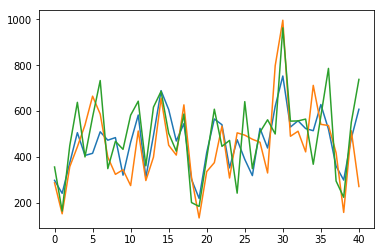

In [178]:
idx = 40
print(max_val[idx])
print(idx)
my_ssm = LDEuler(r=2., b=b_val[idx], sigma=0.6, tau=0.06)
X, y = my_ssm.simulate(41)
simulate_plot(my_ssm)

### Implementation of the PMCMC

In [129]:
prior_LDEuler = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=10.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = False

if load_model:
    pmmh_LD = pickle.load(open( os.path.join(path,"LDEuler_model.pkl"), "rb" ))
else:
    p_LDEuler = dists.StructDist(prior_LDEuler)
    pmmh_LDEuler= mcmc.PMMH(ssm_cls=LDEuler, prior=p_LDEuler, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_LDEuler.run()
    pickle.dump(pmmh_LDEuler, open( os.path.join(path,"LDEuler_model.pkl"), "wb" ) )

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:32<00:00,  5.74it/s]


mean square jump distance: 0.08335604754846797
posterior loglikelihood: [-574.21727092 -574.21727092 -574.21727092 -574.21727092 -574.21727092]
Acceptance rate: 0.0945472736368184
Last terms of theta chain: [(1.14627796e-05, 0.07287079, 0.06268267, 0.28869454)
 (1.14627796e-05, 0.07287079, 0.06268267, 0.28869454)
 (1.14627796e-05, 0.07287079, 0.06268267, 0.28869454)]


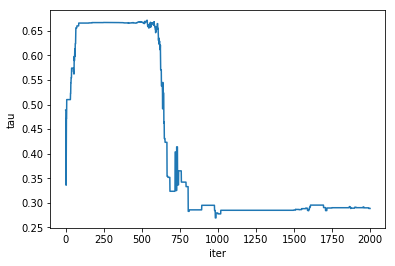

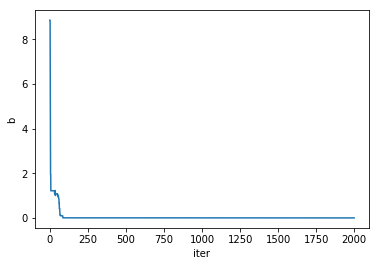

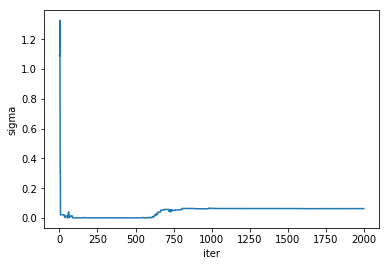

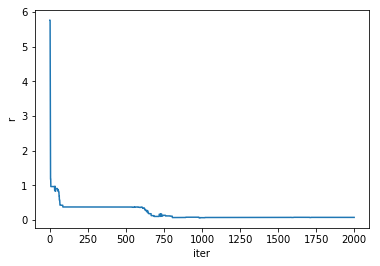

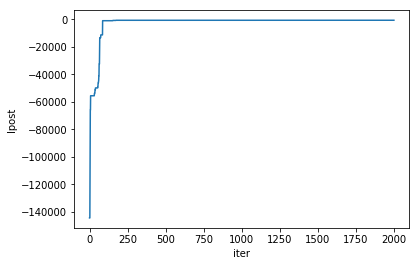

In [184]:
print_metrics(pmmh_LDEuler)
plot_theta(prior_LDEuler,pmmh_LDEuler)

In [185]:
simulLDEuler = get_trajectories(N=100, start=500, model='LDEuler', pmmh=pmmh_LDEuler, n_particles=10000)

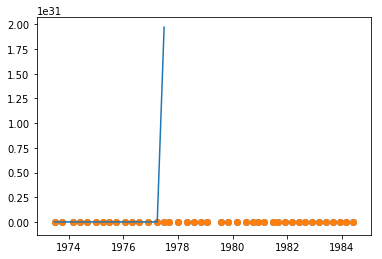

In [186]:
plot_posterior_trajectories(simulLDEuler)

# Test with new Adaptative method

We now use the three steps Adaptative method proposed by Knape & De Valpine (2012). We focus our experiments on the three models detailed in the paper: Random Walk (M3), Exponential growth (M2) and Logistic Diffusion with Euler Discretization (M1).

## Random Walk model

In [10]:
prior_RW = {'tau': dists.Uniform(a=0.,b=1.),'sigma': dists.Uniform(a=0.,b=10.)}
p_RW = dists.StructDist(prior_RW)
load_model = False

if load_model:
    pmmh_RW = pickle.load(open( os.path.join(path,"RW_model_Adapt.pkl"), "rb" ))
else:
    new_pmmh_RW= AdaptivePMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles, niter=3000, adaptive=True,
                          m1=1000, m2=2000, update_interv=100, w01=0.4, w02=0.5, w1=0.8, k0=5., k1=5.)
    new_pmmh_RW.run()
    # pickle.dump(pmmh_RW, open( os.path.join(path,"RW_model_Adapt.pkl"), "wb" ) )

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:58<00:00,  9.56it/s]


mean square jump distance: 17.447577327019516
posterior loglikelihood: [-536.81532933 -536.81532933 -536.81532933 -536.81532933 -536.81532933]
Acceptance rate: 0.15271757252417473
Last terms of theta chain: [(0.51876581, 0.05101768) (0.51876581, 0.05101768)
 (0.51876581, 0.05101768)]


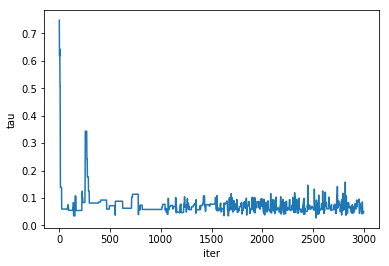

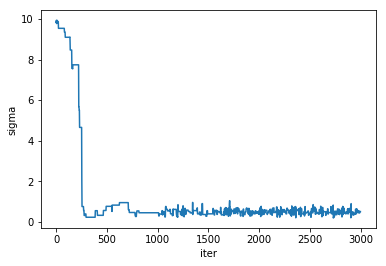

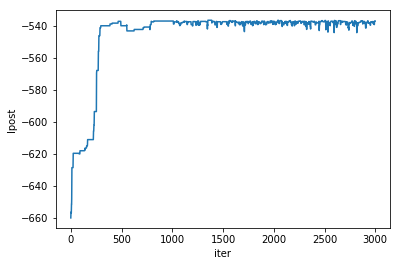

In [11]:
print_metrics(new_pmmh_RW)
plot_theta(prior_RW,new_pmmh_RW)

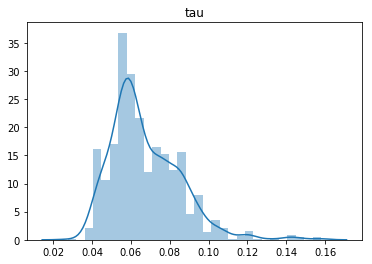

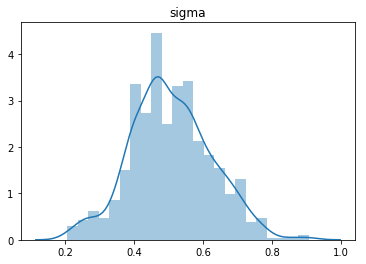

In [12]:
distplot(prior_RW, new_pmmh_RW, 2000)

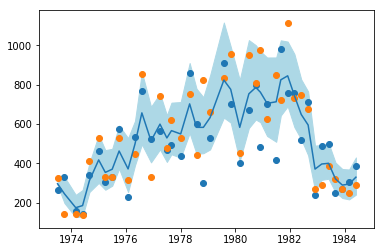

In [13]:
simulRW_new = get_trajectories(N=100, start=2000, model='RW', pmmh=new_pmmh_RW, n_particles=10000)
plot_posterior_trajectories(simulRW_new)

## Exponential Growth (M2)

In [14]:
prior_EG = {'tau': dists.Uniform(a=0.,b=1.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}

load_model = False

if load_model:
    pmmh_Ldrift = pickle.load(open( os.path.join(path,"EG_model.pkl"), "rb" ))
else:
    p_EG = dists.StructDist(prior_EG)
    new_pmmh_EG= AdaptivePMMH(ssm_cls=LDPDrift, prior=p_EG, data=y, Nx=n_particles, niter=3000, adaptive=True,
                          m1=1000, m2=2000, update_interv=100, w01=0.4, w02=0.5, w1=0.8, k0=5., k1=5.)
    new_pmmh_EG.run()
    # pickle.dump(pmmh_Ldrift, open( os.path.join(path,"Ldrift_model.pkl"), "wb" ) )

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:28<00:00, 11.16it/s]


mean square jump distance: 49.690802767510625
posterior loglikelihood: [-539.83393689 -539.83393689 -539.83393689 -539.83393689 -540.88418318]
Acceptance rate: 0.06135378459486496
Last terms of theta chain: [( 0.04479616, 0.528848  , 0.06529433)
 ( 0.04479616, 0.528848  , 0.06529433)
 (-0.13975544, 0.52050691, 0.05015006)]


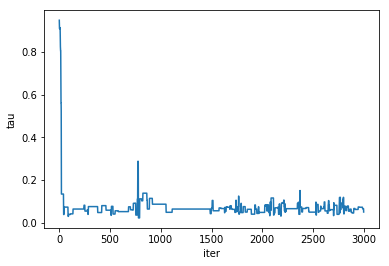

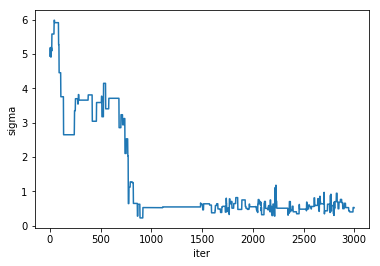

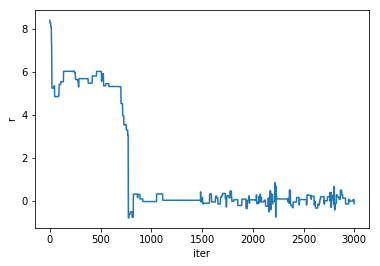

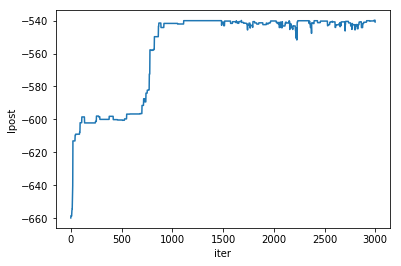

In [15]:
print_metrics(new_pmmh_EG)
plot_theta(prior_EG,new_pmmh_EG)

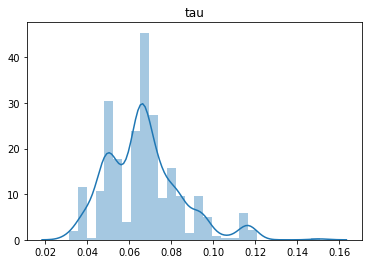

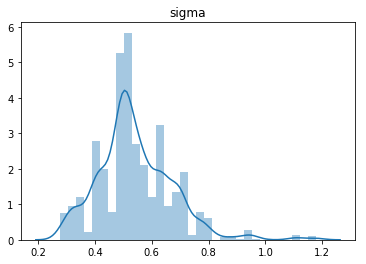

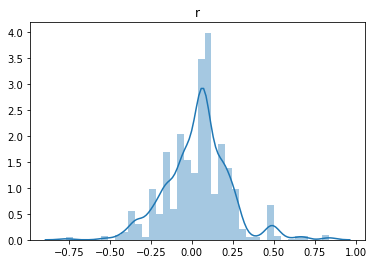

In [16]:
distplot(prior_EG, new_pmmh_EG, 2000)

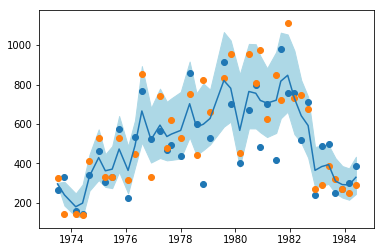

In [17]:
simulEG_new = get_trajectories(N=100, start=2000, model='LDrift', pmmh=new_pmmh_EG, n_particles=10000)
plot_posterior_trajectories(simulEG_new)

## Logistic Diffusion Process with Euler discretization

In [23]:
prior_LDP = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=1.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}

load_model = False

if load_model:
    new_pmmh_LDP = pickle.load(open( os.path.join(path,"new_LDP_model.pkl"), "rb" ))
else:
    p_LDP = dists.StructDist(prior_LDP)
    new_pmmh_LDP= AdaptivePMMH(ssm_cls=LDEuler, prior=p_LDP, data=y, Nx=n_particles, niter=10000, adaptive=True,
                          m1=3000, m2=8000, update_interv=100, w01=0.4, w02=0.5, w1=0.8, k0=5., k1=5.)
    new_pmmh_LDP.run()
    # pickle.dump(pmmh_Ldrift, open( os.path.join(path,"Ldrift_model.pkl"), "wb" ) )

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [20:52<00:00,  6.19it/s]


mean square jump distance: 2.0994283544965358
posterior loglikelihood: [-556.37478177 -556.37478177 -556.37478177 -556.37478177 -556.37478177]
Acceptance rate: 0.0047004700470047005
Last terms of theta chain: [(0.00730192, 3.5871982, 0.61332504, 0.21474873)
 (0.00730192, 3.5871982, 0.61332504, 0.21474873)
 (0.00730192, 3.5871982, 0.61332504, 0.21474873)]


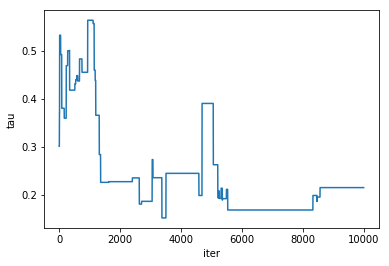

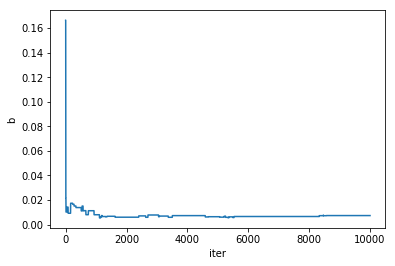

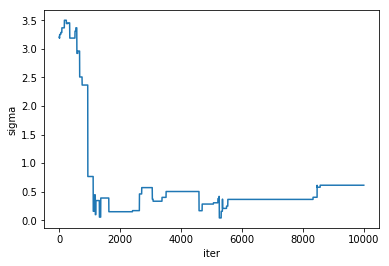

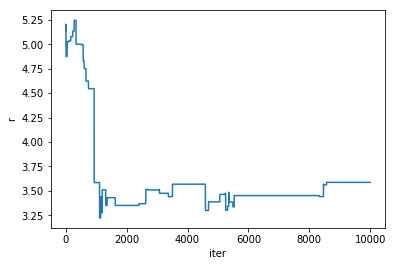

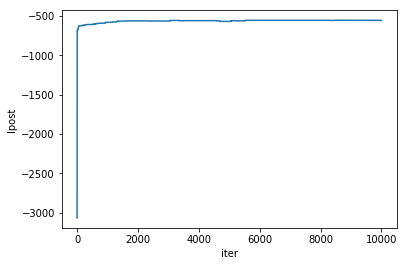

In [24]:
print_metrics(new_pmmh_LDP)
plot_theta(prior_LDP,new_pmmh_LDP)

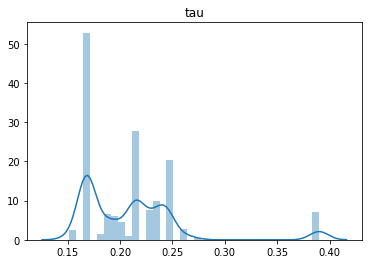

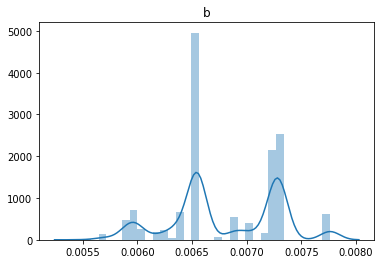

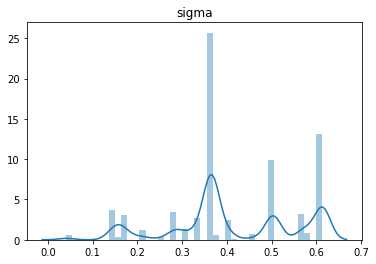

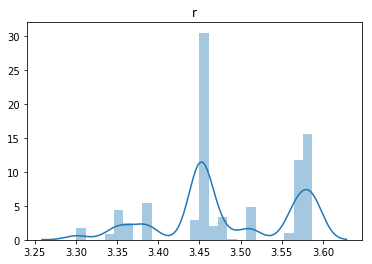

In [25]:
distplot(prior_LDP, new_pmmh_LDP, 2000)

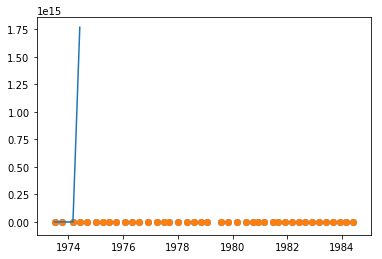

In [27]:
simulLDP_new = get_trajectories(N=100, start=5000, model='LDP', pmmh=new_pmmh_LDP, n_particles=10000)
plot_posterior_trajectories(simulLDP_new)

# Further work

## Guided PF

The main task when working with guided PF is the choice of the guide distribution. A definition of an optimal guide is provided in the lecture, but its exact computation is not tractable in our case. We first look if a Gaussian distribution could be a good approximation for the negative binomial distribution with a simple example similar to our problem.

In [ ]:
L=[]
K=[]
for i in range(100000):
    L.append(dists.NegativeBinomial(n=1/0.06, p=1/(1+0.06*300)).rvs()[0])
    K.append(dists.Normal(loc=300., scale=np.sqrt(300*(1+0.06*300))).rvs())
seaborn.distplot(L)
seaborn.distplot(K)